In [1]:
import pandas as pd
import nltk
nltk.download('stopwords')
nltk.download('punkt_tab')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import time
from nltk.stem import SnowballStemmer

#Visualization
import matplotlib.pyplot as plt

#Feature Engineering
import string
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
#Evaluation Metric
from sklearn.metrics import accuracy_score, confusion_matrix,f1_score, precision_score,recall_score,classification_report
import seaborn as sns
from scipy.sparse import csr_matrix

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# Load dữ liệu

In [2]:
df = pd.read_csv("https://media.githubusercontent.com/media/PTIT-Assignment-Projects/ai-svm-email-spam/refs/heads/main/dataset/sampled_dataset2000.csv")

# Import thư viện

In [3]:
df.head()

,label,text
0,1,wireless optical\n3 - button scroll mouse\nlim...
1,1,from the desk of philip moore\ndept credit con...
2,1,submitting your website in search engines may ...
3,1,managers wanted inc escapenumber company is lo...
4,1,anatrim an extremely efficient flesh loss blen...


In [4]:
df.shape

(2000, 2)

## Kiểm tra dữ liệu

### Kiểm tra dữ liệu bị thiếu

In [5]:
df.isnull().sum()

label    0
text     0
dtype: int64

### Kiểm tra dữ liệu trùng lặp

In [6]:
df.duplicated().sum()

0

## EDA

### Tỉ lệ email spam / không spam

In [7]:
label_counts = df['label'].value_counts()
print(label_counts)

label
1    1052
0     948
Name: count, dtype: int64


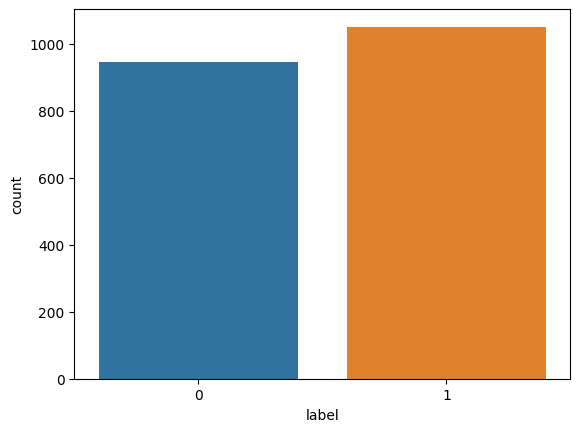

In [8]:
sns.countplot(x='label', data=df)
plt.show()

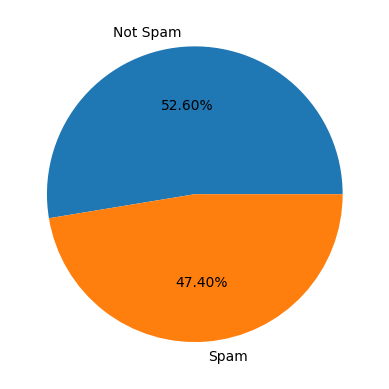

In [9]:
labels = {
    0: 'Not Spam',
    1: 'Spam'
}
plt.pie(label_counts, labels = labels.values(), autopct = "%.2f%%")
plt.show()

# Tiền xử lý dữ liệu


## Xoá những ký tự đặc biệt và số

In [10]:
def remove_special_characters(word):
    return re.sub(r'[^a-zA-Z\s]', '', word)

In [11]:
text = 'Hello everyone ! I am happy to meet 3 of us, my email is admin@gmail.com'
print(remove_special_characters(text))

Hello everyone  I am happy to meet  of us my email is admingmailcom


## Xoá những stop words trong câu

https://www.coursera.org/articles/what-are-stop-words


https://www.geeksforgeeks.org/removing-stop-words-nltk-python/

In [12]:
ENGLISH_STOP_WORDS = set(stopwords.words('english'))


In [13]:
def remove_stop_words(words):
    return [word for word in words if word not in ENGLISH_STOP_WORDS]

In [14]:
print(' '.join(remove_stop_words(text.split())))

Hello everyone ! I happy meet 3 us, email admin@gmail.com


## Xoá các link website trong câu

In [15]:
def remove_url(word):
    return re.sub(r"http\S+", "", word)

In [16]:
text = 'My websites are https://google.com and https://reddit.com'
print(remove_url(text))

My websites are  and 


## Áp dụng vào data

https://www.nltk.org/api/nltk.tokenize.word_tokenize.html
https://www.geeksforgeeks.org/python-nltk-nltk-tokenizer-word_tokenize/

https://www.geeksforgeeks.org/tokenize-text-using-nltk-python/


In [17]:
df['text'] = df['text'].apply(remove_special_characters)
df['text'] = df['text'].apply(remove_url)
df['text'] = df['text'].apply(word_tokenize)
df['text'] = df['text'].apply(remove_stop_words)
df['text'] = df['text'].apply(' '.join)

In [18]:
df.head()

,label,text
0,1,wireless optical button scroll mouse limited s...
1,1,desk philip moore dept credit control unit uni...
2,1,submitting website search engines may increase...
3,1,managers wanted inc escapenumber company looki...
4,1,anatrim extremely efficient flesh loss blend r...


## Snowball Stemmer
https://www.geeksforgeeks.org/snowball-stemmer-nlp/

In [19]:
stemmer = SnowballStemmer('english')

def stem_text(text):
    tokens = nltk.word_tokenize(text)

    stemmed_tokens = [stemmer.stem(token) for token in tokens]

    return ' '.join(stemmed_tokens)

In [20]:
df['text'] = df['text'].apply(stem_text)
df.head()

,label,text
0,1,wireless optic button scroll mous limit stock ...
1,1,desk philip moor dept credit control unit unio...
2,1,submit websit search engin may increas onlin s...
3,1,manag want inc escapenumb compani look manag g...
4,1,anatrim extrem effici flesh loss blend readili...


## TF-IDF vectorization

https://www.geeksforgeeks.org/understanding-tf-idf-term-frequency-inverse-document-frequency/

In [21]:
vectorizer = TfidfVectorizer()

X = vectorizer.fit_transform(df['text'])
print(X.shape)



(2000, 26318)


# Chuẩn bị dữ liệu train và test

In [22]:
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Viết class SVM

##Import

In [23]:
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

##Linear SVM Hard Margin


### Lý thuyết


In [24]:
class LinearSVM_HardMargin:
    def __init__(self, learning_rate=0.001, lambda_param=0.01, n_iters=1000):
        self.lr = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.w = None
        self.b = None

    def fit(self, X, y):

        if hasattr(X, "toarray"):
            X = X.toarray()

        n_samples, n_features = X.shape


        y_ = np.where(y <= 0, -1, 1)


        self.w = np.zeros(n_features)
        self.b = 0


        for _ in range(self.n_iters):
            for idx, x_i in enumerate(X):
                condition = y_[idx] * (np.dot(x_i, self.w) - self.b) >= 1
                if condition:
                    self.w -= self.lr * (2 * self.lambda_param * self.w)
                else:
                    self.w -= self.lr * (2 * self.lambda_param * self.w - np.dot(x_i, y_[idx]))
                    self.b -= self.lr * y_[idx]

    def predict(self, X):

        if hasattr(X, "toarray"):
            X = X.toarray()

        linear_output = np.dot(X, self.w) - self.b
        return np.where(linear_output <= 0, 0, 1)

## Linear SVM Hard Margin V2 - Dương

In [25]:
class HardMarginSVM:
    def __init__(self, eta=0.001, epoch=1000, random_state=42):
        self.eta = eta
        self.epoch = epoch
        self.random_state = random_state
        self.is_trained = False
        self.support_vectors = None

    def fit(self, X, y):
        if hasattr(X, "toarray"):
            X = X.toarray()
        self.num_samples = X.shape[0]
        self.num_features = X.shape[1]
        y_unique = np.unique(y)
        if len(y_unique) != 2:
            raise ValueError("Binary classification requires exactly 2 classes")
        if set(y_unique) == {0, 1}:
            y = np.where(y == 0, -1, 1)
        self.w = np.zeros(self.num_features)
        self.b = 0
        rgen = np.random.RandomState(self.random_state)
        self.alpha = rgen.uniform(low=0.0, high=0.01, size=self.num_samples)
        for i in range(self.epoch):
            self._cycle(X, y)
        sv_indices = np.where(self.alpha != 0)[0]
        self.support_vectors = sv_indices
        self.w = np.zeros(self.num_features)
        for i in sv_indices:
            self.w += self.alpha[i] * y[i] * X[i]
        bias_sum = 0
        for i in sv_indices:
            bias_sum += y[i] - np.dot(self.w, X[i])
        self.b = bias_sum / len(sv_indices)
        self.is_trained = True
        return self

    def predict(self, X):
        if not self.is_trained:
            raise Exception('Model not trained yet')
        if hasattr(X, "toarray"):
            X = X.toarray()
        decision_values = X @ self.w + self.b
        result = np.where(decision_values >= 0, 1, 0)
        return result
    def _cycle(self, X, y):
        y = y.reshape([-1, 1]) #(n,1)
        XXT = X @ X.T
        H = (y @ y.T) * XXT
        grad = np.ones(self.num_samples) - H @ self.alpha
        self.alpha += self.eta * grad
        self.alpha = np.clip(self.alpha, 0, None)


##SVM tối ưu sử dụng thuật toán Pegasos

### Lý thuyết

In [26]:
class SVM:
    def __init__(self, lambda_param=1e-4, epoch=1000, batch_size=256, tol=1e-4, random_state=42):
        self.lambda_param = lambda_param
        self.epoch = epoch
        self.batch_size = batch_size
        self.tol = tol
        self.random_state = random_state
        self.is_trained = False

    def fit(self, X, y):
        if hasattr(X, "toarray"):
            X = csr_matrix(X)

        self.num_samples, self.num_features = X.shape

        y_unique = np.unique(y)
        if len(y_unique) != 2:
            raise ValueError("Phân loại nhị phân cần 2 nhãn")
        if set(y_unique) == {0, 1}:
            y = np.where(y == 0, -1, 1)

        self.w = np.zeros(self.num_features, dtype=np.float32)
        self.b = 0.0

        np.random.seed(self.random_state)
        t = 0
        previous_objective = float("inf")

        for ep in range(1, self.epoch + 1):
            indices = np.random.permutation(self.num_samples)
            for start in range(0, self.num_samples, self.batch_size):
                t += 1
                end = start + self.batch_size
                batch_idx = indices[start:end]
                X_batch = X[batch_idx]
                y_batch = y[batch_idx]

                eta = 1.0 / (self.lambda_param * t)
                margins = y_batch * (X_batch.dot(self.w) + self.b)
                mask = margins < 1
                self.w *= (1 - eta * self.lambda_param)
                if np.any(mask):
                    X_violate = X_batch[mask]
                    y_violate = y_batch[mask]
                    self.w += (eta / self.batch_size) * np.dot(y_violate, X_violate.toarray() if hasattr(X_violate, "toarray") else X_violate)
                    self.b += (eta / self.batch_size) * np.sum(y_violate)
                norm_w = np.linalg.norm(self.w)
                factor = min(1, (1.0 / np.sqrt(self.lambda_param)) / (norm_w))
                self.w *= factor

            decision = X.dot(self.w) + self.b
            hinge_losses = np.maximum(0, 1 - y * decision)
            objective = 0.5 * self.lambda_param * np.dot(self.w, self.w) + np.mean(hinge_losses)

            if ep % 10 == 0:
                print(f"Epoch {ep}, Giá trị hàm mục tiêu: {objective:.4f}")

            if abs(previous_objective - objective) < self.tol:
                print(f"Dừng sớm tại epoch {ep}, giá trị hàm mục tiêu thay đổi: {abs(previous_objective - objective):.6f}")
                break
            previous_objective = objective

        self.is_trained = True
        return self

    def predict(self, X):
        if not self.is_trained:
            raise Exception("Mô hình chưa được huấn luỵen")

        if hasattr(X, "toarray"):
            X = csr_matrix(X)

        decision = X.dot(self.w) + self.b
        return np.where(decision >= 0, 1, 0)

##Đánh giá

In [27]:
def evaluate_model(model, X_test, y_test, model_name="Model"):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f"===== Kết quả đánh giá {model_name} =====")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print("\nBáo cáo chi tiết:")
    print(classification_report(y_test, y_pred))


##Thực thi và so sánh mô hình

In [28]:
print("Đang huấn luyện SVM...")
start = time.time()
svm = HardMarginSVM()
svm.fit(X_train, y_train)
end = time.time()

# print("\n=== Đánh giá Hard Margin SVM ===")
# hard_margin_results = evaluate_model(hard_margin_svm, X_test, y_test, "Hard Margin SVM")
print("Thời gian chạy: ", end - start)
print("\n=== Đánh giá Hard Margin SVM ===")
results = evaluate_model(svm, X_test, y_test, "Hard Margin SVM")


Đang huấn luyện SVM...
Thời gian chạy:  1030.955427646637

=== Đánh giá Hard Margin SVM ===
===== Kết quả đánh giá Hard Margin SVM =====
Accuracy: 0.9450
Precision: 0.9375
Recall: 0.9559
F1-score: 0.9466

Báo cáo chi tiết:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       196
           1       0.94      0.96      0.95       204

    accuracy                           0.94       400
   macro avg       0.95      0.94      0.94       400
weighted avg       0.95      0.94      0.94       400

